# CNN Model Training

This notebook contains model training process for CNN model on three different deepfake detection datasets. The model training splitted into two parts, which are baseline model (base model without dropout) and the dropout model itself.

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
import pickle
import os

## Define Dataset Directory

In [2]:
CDF_DATASET_DIR = "/kaggle/input/deepfake-detection-datasets/Celeb-DF-v2"
DF_DATASET_DIR = "/kaggle/input/deepfake-detection-datasets/DeeperForensics-1.0"
DFDC_DATASET_DIR = "/kaggle/input/deepfake-detection-datasets/DFDC"

In [3]:
cdf_train_dir = os.path.join(CDF_DATASET_DIR, "Train")
cdf_val_dir = os.path.join(CDF_DATASET_DIR, "Val")

df_train_dir = os.path.join(DF_DATASET_DIR, "Train")
df_val_dir = os.path.join(DF_DATASET_DIR, "Val")

dfdc_train_dir = os.path.join(DFDC_DATASET_DIR, "Train")
dfdc_val_dir = os.path.join(DFDC_DATASET_DIR, "Val")

## Image Data Generator for Each Dataset

In [4]:
def create_image_generator(dataset_dir):
    datagen = ImageDataGenerator(rescale=1./255)
    image_generator = datagen.flow_from_directory(
        dataset_dir,
        target_size=(128, 128),
        batch_size=32,
        color_mode="rgb",
        class_mode="binary",
        shuffle=True,
        seed=42
    )

    return image_generator

In [5]:
print("Celeb-DF-v2 Dataset")
cdf_train_generator = create_image_generator(cdf_train_dir)
cdf_val_generator = create_image_generator(cdf_val_dir)

print("\nDeeperForensics-1.0 Dataset")
df_train_generator = create_image_generator(df_train_dir)
df_val_generator = create_image_generator(df_val_dir)

print("\nDeepfake Detection Challenge Dataset")
dfdc_train_generator = create_image_generator(dfdc_train_dir)
dfdc_val_generator = create_image_generator(dfdc_val_dir)

Celeb-DF-v2 Dataset
Found 14000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.

DeeperForensics-1.0 Dataset
Found 14000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.

Deepfake Detection Challenge Dataset
Found 14000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## Get the Best Hyperparameters from Tuner

In [6]:
TUNER_RESULT_DIR = "/kaggle/input/hyperparameter-tuning/tuner_result"
BASE_HP_TUNER_PROJECT_NAME = "base_hp"
DROPOUT_TUNER_PROJECT_NAME = "dropout_rate"

In [7]:
def get_best_hp_from_tuner(tuner_dir, project_name):
    tuner = kt.Hyperband(directory=tuner_dir,
                         project_name=project_name,
                         overwrite=False)

    best_hp = tuner.get_best_hyperparameters()[0].values
    return best_hp

### Base Hyperparameters

In [8]:
best_base_hp = get_best_hp_from_tuner(TUNER_RESULT_DIR, BASE_HP_TUNER_PROJECT_NAME)
best_base_hp

Reloading Tuner from /kaggle/input/hyperparameter-tuning/tuner_result/base_hp/tuner0.json


{'conv_layers': 4,
 'conv_1_filters': 256,
 'conv_2_filters': 224,
 'conv_3_filters': 256,
 'conv_1_kernel_size': 3,
 'conv_2_kernel_size': 3,
 'conv_3_kernel_size': 3,
 'dense_layers': 4,
 'dense_1_layer_units': 64,
 'dense_2_layer_units': 224,
 'learning_rate': 1e-05,
 'conv_4_filters': 256,
 'conv_4_kernel_size': 7,
 'dense_3_layer_units': 224,
 'dense_4_layer_units': 224,
 'dense_5_layer_units': 224,
 'conv_5_filters': 192,
 'conv_5_kernel_size': 3,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

### Dropout Hyperparameter

In [9]:
best_dropout_hp = get_best_hp_from_tuner(TUNER_RESULT_DIR, DROPOUT_TUNER_PROJECT_NAME)
best_dropout_hp

Reloading Tuner from /kaggle/input/hyperparameter-tuning/tuner_result/dropout_rate/tuner0.json


{'dropout_rate': 0.65,
 'tuner/epochs': 3,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 2,
 'tuner/round': 0}

### Combine All Hyperparameters into a Dict

In [10]:
best_hp = {}

best_hp["conv_layers"] = best_base_hp.get("conv_layers")
for i in range(best_base_hp.get("conv_layers")):
    conv_filter_hp_name = f"conv_{i+1}_filters"
    conv_kernel_size_hp_name = f"conv_{i+1}_kernel_size"
    best_hp[conv_filter_hp_name] = best_base_hp.get(conv_filter_hp_name)
    best_hp[conv_kernel_size_hp_name] = best_base_hp.get(conv_kernel_size_hp_name)

best_hp["dense_layers"] = best_base_hp.get("dense_layers")
for i in range(best_base_hp.get("dense_layers")):
    dense_unit_hp_name = f"dense_{i+1}_layer_units"
    best_hp[dense_unit_hp_name] = best_base_hp.get(dense_unit_hp_name)

best_hp["dropout_rate"] = best_dropout_hp.get("dropout_rate")
best_hp["learning_rate"] = best_base_hp.get("learning_rate")

print("Best hyperparameters loaded\n")
for key in best_hp:
    print(f"{key}: {best_hp[key]}")

Best hyperparameters loaded

conv_layers: 4
conv_1_filters: 256
conv_1_kernel_size: 3
conv_2_filters: 224
conv_2_kernel_size: 3
conv_3_filters: 256
conv_3_kernel_size: 3
conv_4_filters: 256
conv_4_kernel_size: 7
dense_layers: 4
dense_1_layer_units: 64
dense_2_layer_units: 224
dense_3_layer_units: 224
dense_4_layer_units: 224
dropout_rate: 0.65
learning_rate: 1e-05


## Function to Create a CNN Model

In [11]:
def create_cnn_model(hp, dropout=False):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(128, 128, 3)))

    for i in range(hp.get("conv_layers")):
        filter = hp.get(f"conv_{i+1}_filters")
        kernel_size = hp.get(f"conv_{i+1}_kernel_size")
        model.add(
            tf.keras.layers.Conv2D(
                filter, (kernel_size, kernel_size), activation="relu"
            )
        )
        model.add(tf.keras.layers.MaxPooling2D(2, 2))

    model.add(tf.keras.layers.Flatten())

    for i in range(hp.get("dense_layers")):
        dense_units = hp.get(f"dense_{i+1}_layer_units")
        model.add(tf.keras.layers.Dense(dense_units, activation="relu"))

    if dropout:
        model.add(tf.keras.layers.Dropout(hp.get("dropout_rate")))

    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.get("learning_rate")),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=["accuracy"]
    )

    return model

## Function to Plot Train Results

In [12]:
def plot_train_result(history, title="Training Result"):
    plt.figure(figsize=(12, 4))
    plt.subplots_adjust(top=0.8)
    plt.suptitle(title)

    plt.subplot(1, 2, 1)
    plt.plot(history["accuracy"], label="Train")
    plt.plot(history["val_accuracy"], label="Val")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["loss"], label="Train")
    plt.plot(history["val_loss"], label="Val")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

## Function to Save Model Training History

In [13]:
def save_model_and_history(model, history, model_name):
    model_filename = f"{model_name}_model.keras"
    history_filename = f"{model_name}_history.pkl"

    model.save(model_filename)
    print(f"Model saved at {model_filename}")    

    with open(history_filename, "wb") as f:
        pickle.dump(history.history, f)
        print(f"Training history saved at {history_filename}")

## Model Training

In [14]:
NUM_EPOCHS = 50

### Baseline CNN

#### Celeb-DF-v2 Dataset

In [15]:
baseline_cnn_cdf_model = create_cnn_model(best_hp)
baseline_cnn_cdf_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 256)  │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 224)    │       516,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 224)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 256)    │       516,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 224)            │        14,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 224)            │        50,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 224)            │        50,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,629,153 (17.66 MB)

 Trainable params: 4,629,153 (17.66 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
baseline_cnn_cdf_history = baseline_cnn_cdf_model.fit(
    cdf_train_generator, validation_data=cdf_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730744239.880733     256 service.cc:145] XLA service 0x78d254002520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730744239.880796     256 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/438 ━━━━━━━━━━━━━━━━━━━━ 24s 56ms/step - accuracy: 0.4297 - loss: 0.6944   

I0000 00:00:1730744247.473407     256 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


438/438 ━━━━━━━━━━━━━━━━━━━━ 259s 566ms/step - accuracy: 0.4952 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6928
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 26s 58ms/step - accuracy: 0.5200 - loss: 0.6911 - val_accuracy: 0.6355 - val_loss: 0.6740
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 25s 57ms/step - accuracy: 0.6547 - loss: 0.6433 - val_accuracy: 0.6335 - val_loss: 0.6359
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - accuracy: 0.7228 - loss: 0.5623 - val_accuracy: 0.6245 - val_loss: 0.6639
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 26s 58ms/step - accuracy: 0.7681 - loss: 0.5057 - val_accuracy: 0.6390 - val_loss: 0.6770
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 26s 58ms/step - accuracy: 0.8090 - loss: 0.4405 - val_accuracy: 0.6665 - val_loss: 0.6989
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 26s 58ms/step - accuracy: 0.8459 - loss: 0.3739 - val_accuracy: 0.6645 - val_loss: 0.7878
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 26s 57ms/step - accuracy: 0.8807 - loss: 0.3149 - val_accur

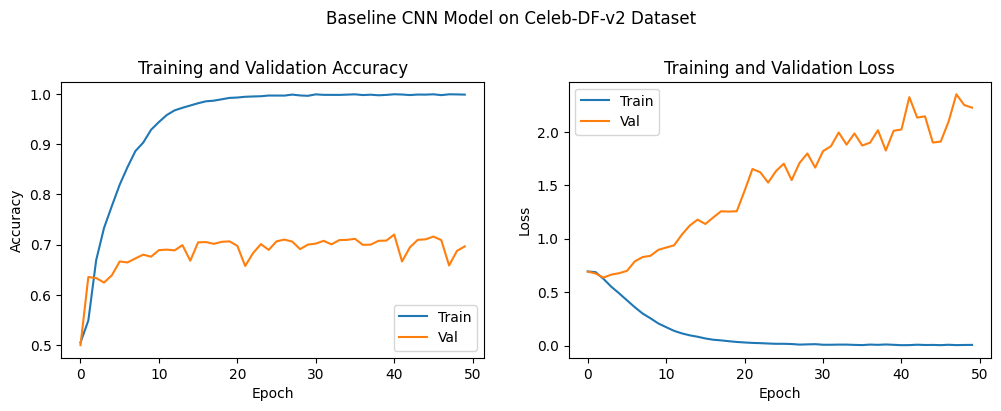

In [17]:
plot_train_result(
    baseline_cnn_cdf_history.history,
    title="Baseline CNN Model on Celeb-DF-v2 Dataset"
)

In [18]:
save_model_and_history(
    baseline_cnn_cdf_model, baseline_cnn_cdf_history, "baseline_cnn_cdf"
)

Model saved at baseline_cnn_cdf_model.keras
Training history saved at baseline_cnn_cdf_history.pkl


#### DeeperForensics-1.0 Dataset

In [19]:
baseline_cnn_df_model = create_cnn_model(best_hp)
baseline_cnn_df_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 126, 126, 256)  │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 61, 224)    │       516,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 224)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       516,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 256)      │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 224)            │        14,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 224)            │        50,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 224)            │        50,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,629,153 (17.66 MB)

 Trainable params: 4,629,153 (17.66 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
baseline_cnn_df_history = baseline_cnn_df_model.fit(
    df_train_generator, validation_data=df_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 171s 377ms/step - accuracy: 0.5818 - loss: 0.6571 - val_accuracy: 0.8545 - val_loss: 0.3415
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 72s 88ms/step - accuracy: 0.9330 - loss: 0.1932 - val_accuracy: 0.9155 - val_loss: 0.1936
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 37s 82ms/step - accuracy: 0.9802 - loss: 0.0728 - val_accuracy: 0.9185 - val_loss: 0.2009
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 40s 79ms/step - accuracy: 0.9890 - loss: 0.0412 - val_accuracy: 0.9165 - val_loss: 0.2301
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 36s 81ms/step - accuracy: 0.9934 - loss: 0.0268 - val_accuracy: 0.9225 - val_loss: 0.2621
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 36s 81ms/step - accuracy: 0.9945 - loss: 0.0222 - val_accuracy: 0.9215 - val_loss: 0.2673
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 34s 78ms/step - accuracy: 0.9965 - loss: 0.0129 - val_accuracy: 0.9195 - val_loss: 0.2718
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 36s 79ms/step - accuracy: 0.9972 - loss: 0.0113 

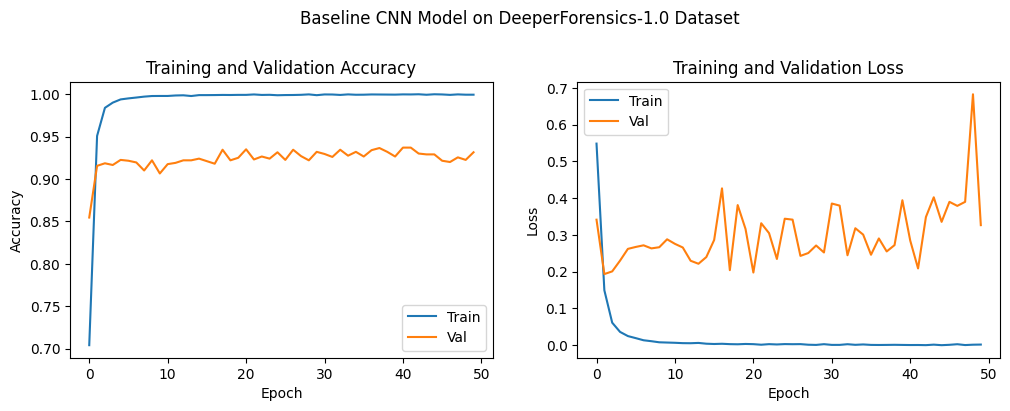

In [21]:
plot_train_result(
    baseline_cnn_df_history.history,
    title="Baseline CNN Model on DeeperForensics-1.0 Dataset"
)

In [22]:
save_model_and_history(
    baseline_cnn_df_model, baseline_cnn_df_history, "baseline_cnn_df"
)

Model saved at baseline_cnn_df_model.keras
Training history saved at baseline_cnn_df_history.pkl


#### DFDC Dataset

In [23]:
baseline_cnn_dfdc_model = create_cnn_model(best_hp)
baseline_cnn_dfdc_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 126, 126, 256)  │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 63, 63, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 61, 61, 224)    │       516,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 30, 30, 224)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 256)    │       516,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 256)      │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 224)            │        14,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 224)            │        50,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 224)            │        50,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,629,153 (17.66 MB)

 Trainable params: 4,629,153 (17.66 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
baseline_cnn_dfdc_history = baseline_cnn_dfdc_model.fit(
    dfdc_train_generator, validation_data=dfdc_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 135s 296ms/step - accuracy: 0.5127 - loss: 0.6922 - val_accuracy: 0.4990 - val_loss: 0.6893
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/step - accuracy: 0.6052 - loss: 0.6539 - val_accuracy: 0.4835 - val_loss: 0.8326
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 29s 65ms/step - accuracy: 0.7088 - loss: 0.5587 - val_accuracy: 0.5335 - val_loss: 1.0017
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.8005 - loss: 0.4368 - val_accuracy: 0.5845 - val_loss: 1.0867
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.8618 - loss: 0.3284 - val_accuracy: 0.5900 - val_loss: 1.2446
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/step - accuracy: 0.9014 - loss: 0.2536 - val_accuracy: 0.5930 - val_loss: 1.3683
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/step - accuracy: 0.9320 - loss: 0.1987 - val_accuracy: 0.6110 - val_loss: 1.3894
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/step - accuracy: 0.9522 - loss: 0.1522 

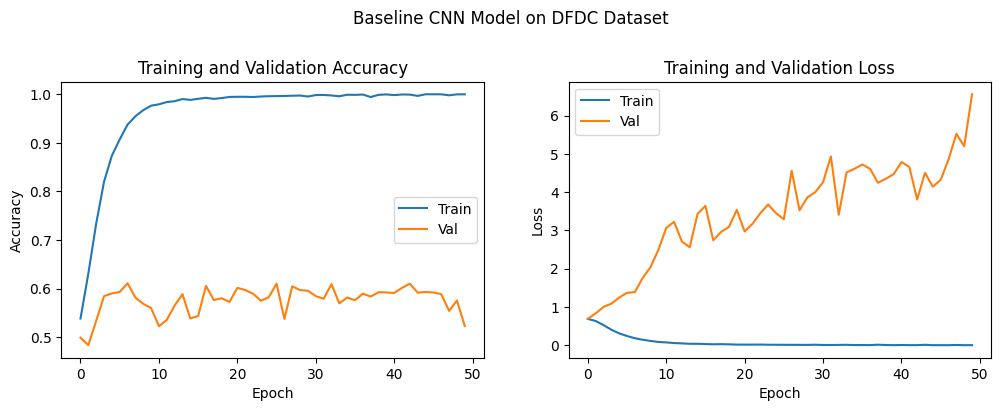

In [25]:
plot_train_result(
    baseline_cnn_dfdc_history.history,
    title="Baseline CNN Model on DFDC Dataset"
)

In [26]:
save_model_and_history(
    baseline_cnn_dfdc_model, baseline_cnn_dfdc_history, "baseline_cnn_dfdc"
)

Model saved at baseline_cnn_dfdc_model.keras
Training history saved at baseline_cnn_dfdc_history.pkl


### Dropout CNN Model Training

#### Celeb-DF-v2 Dataset

In [27]:
dropout_cnn_cdf_model = create_cnn_model(best_hp, dropout=True)
dropout_cnn_cdf_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 126, 126, 256)  │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 63, 63, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 61, 61, 224)    │       516,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 30, 30, 224)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 256)    │       516,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 8, 8, 256)      │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 224)            │        14,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 224)            │        50,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 224)            │        50,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,629,153 (17.66 MB)

 Trainable params: 4,629,153 (17.66 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
dropout_cnn_cdf_history = dropout_cnn_cdf_model.fit(
    cdf_train_generator, validation_data=cdf_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 51s 103ms/step - accuracy: 0.5045 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6926
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/step - accuracy: 0.5240 - loss: 0.6917 - val_accuracy: 0.5960 - val_loss: 0.6848
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 40s 61ms/step - accuracy: 0.5891 - loss: 0.6736 - val_accuracy: 0.5625 - val_loss: 0.6711
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 68ms/step - accuracy: 0.6737 - loss: 0.6138 - val_accuracy: 0.6370 - val_loss: 0.6476
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 27s 61ms/step - accuracy: 0.7440 - loss: 0.5396 - val_accuracy: 0.6350 - val_loss: 0.6912
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 27s 62ms/step - accuracy: 0.7770 - loss: 0.4841 - val_accuracy: 0.6695 - val_loss: 0.6837
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 70ms/step - accuracy: 0.8291 - loss: 0.4200 - val_accuracy: 0.6710 - val_loss: 0.7431
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 26s 59ms/step - accuracy: 0.8627 - loss: 0.3491 -

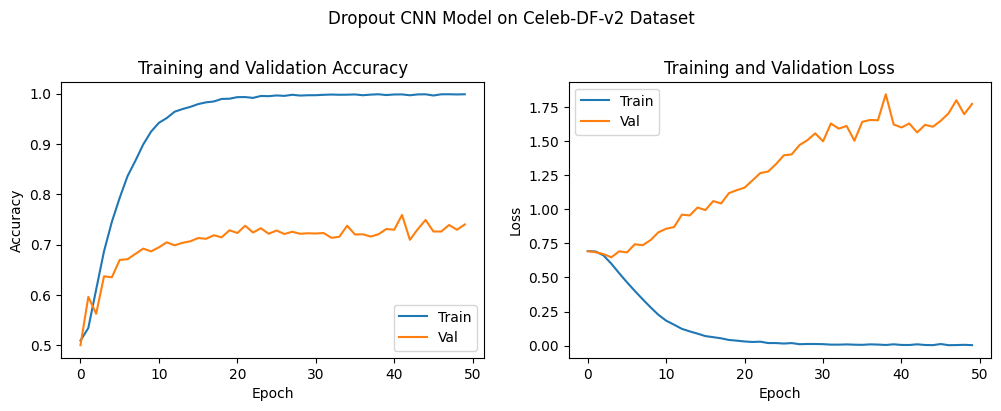

In [29]:
plot_train_result(
    dropout_cnn_cdf_history.history,
    title="Dropout CNN Model on Celeb-DF-v2 Dataset"
)

In [30]:
save_model_and_history(
    dropout_cnn_cdf_model, dropout_cnn_cdf_history, "dropout_cnn_cdf"
)

Model saved at dropout_cnn_cdf_model.keras
Training history saved at dropout_cnn_cdf_history.pkl


#### DeeperForensics-1.0 Dataset

In [31]:
dropout_cnn_df_model = create_cnn_model(best_hp, dropout=True)
dropout_cnn_df_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 126, 126, 256)  │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 63, 63, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 61, 61, 224)    │       516,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 30, 30, 224)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 28, 28, 256)    │       516,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 8, 8, 256)      │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 224)            │        14,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 224)            │        50,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 224)            │        50,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │           225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,629,153 (17.66 MB)

 Trainable params: 4,629,153 (17.66 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
dropout_cnn_df_history = dropout_cnn_df_model.fit(
    df_train_generator, validation_data=df_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 50s 101ms/step - accuracy: 0.5484 - loss: 0.6869 - val_accuracy: 0.8770 - val_loss: 0.4508
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 29s 65ms/step - accuracy: 0.8727 - loss: 0.3356 - val_accuracy: 0.9210 - val_loss: 0.2064
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/step - accuracy: 0.9672 - loss: 0.1027 - val_accuracy: 0.9250 - val_loss: 0.2152
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 64ms/step - accuracy: 0.9846 - loss: 0.0567 - val_accuracy: 0.9235 - val_loss: 0.2422
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 64ms/step - accuracy: 0.9894 - loss: 0.0391 - val_accuracy: 0.9245 - val_loss: 0.2806
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.9930 - loss: 0.0302 - val_accuracy: 0.9225 - val_loss: 0.2857
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 29s 66ms/step - accuracy: 0.9949 - loss: 0.0211 - val_accuracy: 0.9245 - val_loss: 0.2671
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 29s 65ms/step - accuracy: 0.9975 - loss: 0.0129 -

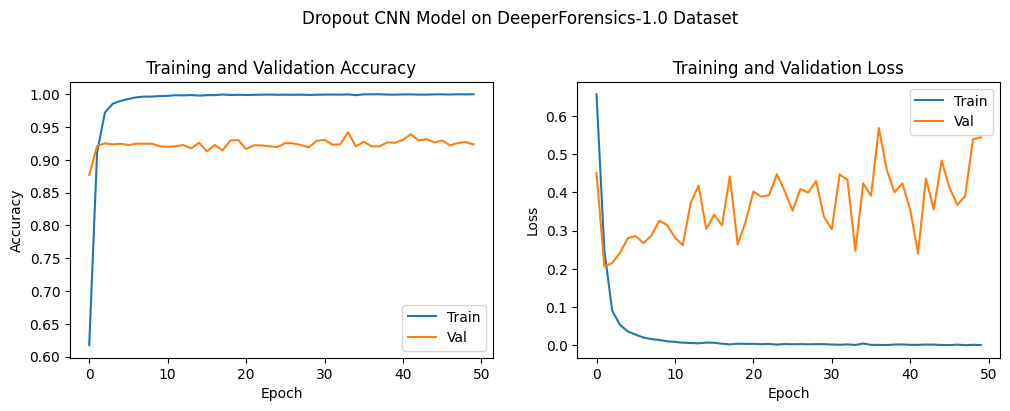

In [33]:
plot_train_result(
    dropout_cnn_df_history.history,
    title="Dropout CNN Model on DeeperForensics-1.0 Dataset"
)

In [34]:
save_model_and_history(
    dropout_cnn_df_model, dropout_cnn_df_history, "dropout_cnn_df"
)

Model saved at dropout_cnn_df_model.keras
Training history saved at dropout_cnn_df_history.pkl


#### DFDC Dataset

In [35]:
dropout_cnn_dfdc_model = create_cnn_model(best_hp, dropout=True)
dropout_cnn_dfdc_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 126, 126, 256)  │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 63, 63, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 61, 61, 224)    │       516,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 30, 30, 224)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 28, 28, 256)    │       516,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 8, 8, 256)      │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 224)            │        14,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 224)            │        50,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 224)            │        50,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │           225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,629,153 (17.66 MB)

 Trainable params: 4,629,153 (17.66 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
dropout_cnn_dfdc_history = dropout_cnn_dfdc_model.fit(
    dfdc_train_generator, validation_data=dfdc_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 59s 118ms/step - accuracy: 0.4984 - loss: 0.6929 - val_accuracy: 0.5605 - val_loss: 0.6919
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 27s 61ms/step - accuracy: 0.5624 - loss: 0.6826 - val_accuracy: 0.5145 - val_loss: 0.6995
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 27s 61ms/step - accuracy: 0.6508 - loss: 0.6250 - val_accuracy: 0.5655 - val_loss: 0.7501
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 27s 62ms/step - accuracy: 0.7684 - loss: 0.4961 - val_accuracy: 0.6045 - val_loss: 0.8448
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 27s 61ms/step - accuracy: 0.8474 - loss: 0.3682 - val_accuracy: 0.6155 - val_loss: 0.9505
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - accuracy: 0.8895 - loss: 0.2764 - val_accuracy: 0.5320 - val_loss: 1.4602
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/step - accuracy: 0.9329 - loss: 0.1954 - val_accuracy: 0.5470 - val_loss: 1.5344
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 27s 61ms/step - accuracy: 0.9575 - loss: 0.1330 -

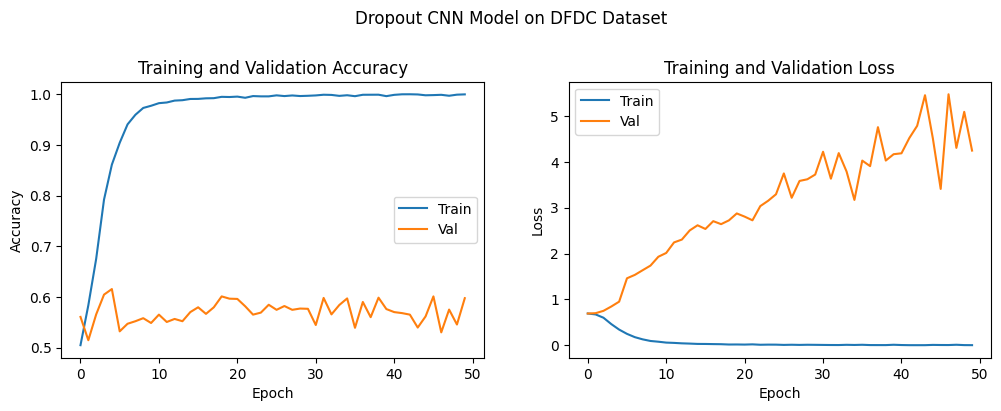

In [37]:
plot_train_result(
    dropout_cnn_dfdc_history.history,
    title="Dropout CNN Model on DFDC Dataset"
)

In [38]:
save_model_and_history(
    dropout_cnn_dfdc_model, dropout_cnn_dfdc_history, "dropout_cnn_dfdc"
)

Model saved at dropout_cnn_dfdc_model.keras
Training history saved at dropout_cnn_dfdc_history.pkl
